In [6]:
import pandas as pd
import requests

API_KEY = "iqvfH4Opi/WZQv4LxZnHovXh1XEro7BHU27d1fgjDpb5U6NWWIeOeVNowX4TVg76"
url = "https://api.collegefootballdata.com/games"
params = {"year": 2023, "seasonType": "regular"}
headers = {"Authorization": f"Bearer {API_KEY}"}

response = requests.get(url, params=params, headers=headers)
df = pd.DataFrame(response.json())
print(f"Got {len(df)} games")
print(df[['homeTeam', 'awayTeam', 'homePoints', 'awayPoints']].head()
)


Got 3595 games
             homeTeam       awayTeam  homePoints  awayPoints
0          Notre Dame           Navy        42.0         3.0
1              Mercer  North Alabama        17.0         7.0
2  Jacksonville State           UTEP        17.0        14.0
3    New Mexico State  Massachusetts        30.0        41.0
4             UAlbany        Fordham        34.0        13.0


In [5]:
print(df.columns.tolist())


['id', 'season', 'week', 'seasonType', 'startDate', 'startTimeTBD', 'completed', 'neutralSite', 'conferenceGame', 'attendance', 'venueId', 'venue', 'homeId', 'homeTeam', 'homeClassification', 'homeConference', 'homePoints', 'homeLineScores', 'homePostgameWinProbability', 'homePregameElo', 'homePostgameElo', 'awayId', 'awayTeam', 'awayClassification', 'awayConference', 'awayPoints', 'awayLineScores', 'awayPostgameWinProbability', 'awayPregameElo', 'awayPostgameElo', 'excitementIndex', 'highlights', 'notes']


In [7]:
# Keep only completed games with valid scores
df_clean = df[
    (df['completed'] == True) &
    (df['homePoints'].notna()) &
    (df['awayPoints'].notna())
].copy()

# Create outcome variables
df_clean['home_margin'] = df_clean['homePoints'] - df_clean['awayPoints']
df_clean['home_win'] = (df_clean['home_margin'] > 0).astype(int)

print(len(df_clean), "games after cleaning")


3585 games after cleaning


In [8]:
df_clean['elo_diff'] = (
    df_clean['homePregameElo'] - df_clean['awayPregameElo']
)

df_clean['wp_diff'] = (
    df_clean['homePostgameWinProbability'] -
    df_clean['awayPostgameWinProbability']
)


In [9]:
df_clean[['home_margin', 'elo_diff']].describe()


,home_margin,elo_diff
count,3585.000000,750.000000
mean,4.516876,18.861333
std,25.487092,279.275851
min,-91.000000,-844.000000
25%,-11.000000,-175.000000
50%,3.000000,18.000000
75%,22.000000,213.000000
max,96.000000,950.000000


In [10]:
df_clean['home_win'].value_counts(normalize=True)


,proportion
home_win,
1,0.56569
0,0.43431


In [11]:
df_model = df[
    (df['completed'] == True) &
    (df['homePoints'].notna()) &
    (df['awayPoints'].notna()) &
    (df['homePregameElo'].notna()) &
    (df['awayPregameElo'].notna())
].copy()

df_model['home_margin'] = df_model['homePoints'] - df_model['awayPoints']
df_model['home_win'] = (df_model['home_margin'] > 0).astype(int)
df_model['elo_diff'] = df_model['homePregameElo'] - df_model['awayPregameElo']

print(len(df_model), "games in final dataset")


750 games in final dataset


In [12]:
import numpy as np

df_model['elo_bin'] = pd.cut(
    df_model['elo_diff'],
    bins=np.arange(-800, 801, 50)
)


In [13]:
elo_summary = (
    df_model
    .groupby('elo_bin')
    .agg(
        games=('home_win', 'count'),
        win_rate=('home_win', 'mean'),
        avg_elo_diff=('elo_diff', 'mean'),
        avg_margin=('home_margin', 'mean')
    )
    .reset_index(drop=True)
)

elo_summary.head()


/tmp/ipython-input-4084927033.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('elo_bin')


,games,win_rate,avg_elo_diff,avg_margin
0,0,NaN,NaN,NaN
1,2,0.0,-737.00,-11.00
2,4,0.0,-663.00,-32.75
3,5,0.2,-617.80,-11.00
4,4,0.0,-575.25,-13.75


In [14]:
elo_summary[['avg_elo_diff', 'win_rate']].describe()


,avg_elo_diff,win_rate
count,30.000000,30.000000
mean,0.789477,0.537154
std,438.895680,0.355951
min,-737.000000,0.000000
25%,-360.358696,0.204054
50%,0.517330,0.610746
75%,363.733934,0.841667
max,721.333333,1.000000


In [15]:
from sklearn.linear_model import LogisticRegression

X = df_model[['elo_diff']]
y = df_model['home_win']

logit = LogisticRegression()
logit.fit(X, y)

df_model['model_prob'] = logit.predict_proba(X)[:, 1]


In [16]:
from sklearn.linear_model import LogisticRegression

X = df_model[['elo_diff']]
y = df_model['home_win']

logit = LogisticRegression()
logit.fit(X, y)

df_model['model_prob'] = logit.predict_proba(X)[:, 1]


In [17]:
df_model['edge'] = df_model['home_win'] - df_model['model_prob']

In [18]:
edge_summary = (
    df_model
    .groupby('elo_bin')
    .agg(
        games=('edge', 'count'),
        avg_edge=('edge', 'mean')
    )
    .reset_index(drop=True)
)

edge_summary.head()


/tmp/ipython-input-2529464476.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('elo_bin')


,games,avg_edge
0,0,NaN
1,2,-0.034972
2,4,-0.049855
3,5,0.138344
4,4,-0.075127


In [19]:
edge_summary = edge_summary[edge_summary['games'] >= 50]
edge_summary.describe()


,games,avg_edge
count,3.000000,3.000000
mean,56.666667,-0.003744
std,0.577350,0.043402
min,56.000000,-0.046478
25%,56.500000,-0.025765
50%,57.000000,-0.005052
75%,57.000000,0.017623
max,57.000000,0.040297


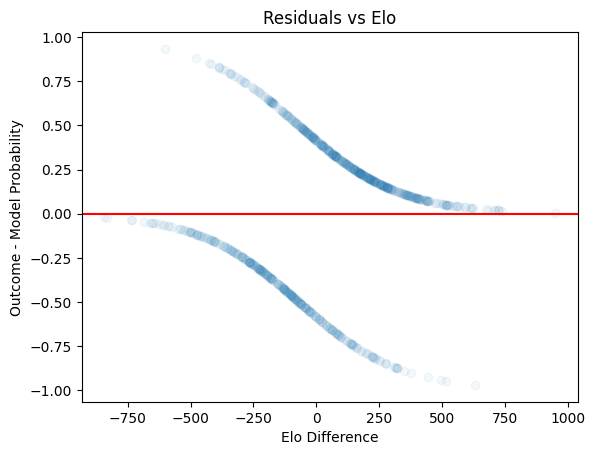

In [20]:
import matplotlib.pyplot as plt

plt.scatter(
    df_model['elo_diff'],
    df_model['home_win'] - df_model['model_prob'],
    alpha=0.05
)
plt.axhline(0, color='red')
plt.xlabel('Elo Difference')
plt.ylabel('Outcome - Model Probability')
plt.title('Residuals vs Elo')
plt.show()


In [21]:
calib = (
    df_model
    .assign(elo_bin=pd.cut(df_model['elo_diff'], bins=30))
    .groupby('elo_bin', observed=True)
    .agg(
        mean_residual=('edge', 'mean'),
        count=('edge', 'count'),
        avg_elo=('elo_diff', 'mean')
    )
)

calib = calib[calib['count'] >= 50]


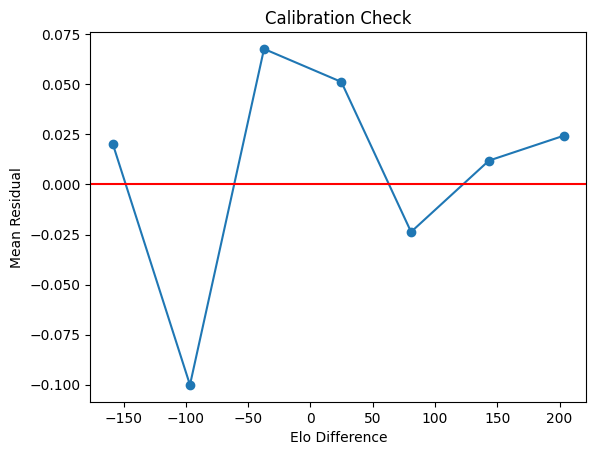

In [22]:
plt.plot(calib['avg_elo'], calib['mean_residual'], marker='o')
plt.axhline(0, color='red')
plt.xlabel('Elo Difference')
plt.ylabel('Mean Residual')
plt.title('Calibration Check')
plt.show()


In [23]:
df_model['home_field'] = (~df_model['neutralSite']).astype(int)

from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(
    df_model[['elo_diff', 'home_field']],
    df_model['home_win']
)


LogisticRegression()

In [24]:
X = df_model[['elo_diff', 'home_field']]
y = df_model['home_win']

logit = LogisticRegression()
logit.fit(X, y)

df_model['model_prob'] = logit.predict_proba(X)[:, 1]
df_model['residual'] = df_model['home_win'] - df_model['model_prob']
